In [1]:
import sys
sys.path.append("C:/Users/user/Documents/esophageal_cancer_cv/src")

from dataset import EsophagealPatchDataset
from transforms import get_train_transforms, get_val_transforms

In [7]:
from torch.utils.data import DataLoader

In [2]:
train_dataset = EsophagealPatchDataset(
    csv_file="C:/Users/user/Documents/esophageal_cancer_cv/data/splits/train.csv",
    transform=get_train_transforms()
)

val_dataset = EsophagealPatchDataset(
    csv_file="C:/Users/user/Documents/esophageal_cancer_cv/data/splits/val.csv",
    transform=get_val_transforms()
)

In [3]:
image, label = train_dataset[0]

print("Image shape:", image.shape)
print("Label:", label)

Image shape: torch.Size([3, 256, 256])
Label: 1


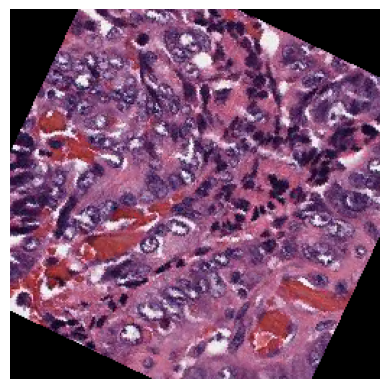

In [4]:
import matplotlib.pyplot as plt
import torch

img = image.permute(1, 2, 0)
img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])

plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [9]:
from model import build_resnet18

model = build_resnet18(num_classes=1)
model = model.to(device)

model

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 2.98MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)

In [11]:
images, labels = next(iter(train_loader))

images = images.to(device)
labels = labels.float().unsqueeze(1).to(device)

outputs = model(images)

print("Outputs shape:", outputs.shape)
print("Labels shape:", labels.shape)

Outputs shape: torch.Size([16, 1])
Labels shape: torch.Size([16, 1])


In [12]:
loss = criterion(outputs, labels)
loss

tensor(0.6947, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [13]:
from train import train_one_epoch, validate

In [14]:
num_epochs = 10
best_val_auc = 0.0

In [ ]:
for epoch in range(1, num_epochs + 1):
    train_loss, train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_metrics = validate(
        model, val_loader, criterion, device
    )

    print(f"Epoch [{epoch}/{num_epochs}]")
    print(f"  Train loss: {train_loss:.4f}")
    print(f"  Train metrics: {train_metrics}")
    print(f"  Val loss:   {val_loss:.4f}")
    print(f"  Val metrics:   {val_metrics}")

    if val_metrics["roc_auc"] > best_val_auc:
        best_val_auc = val_metrics["roc_auc"]
        torch.save(model.state_dict(), "C:/Users/user/Documents/esophageal_cancer_cv/model/best_model.pth")
        print("Best model saved")

Epoch [1/10]
  Train loss: 0.2168
  Train metrics: {'roc_auc': 0.9715386127568266, 'precision': 0.8943261473350086, 'recall': 0.860852959898154, 'f1': 0.8772703684483654}
  Val loss:   0.1200
  Val metrics:   {'roc_auc': 0.9906492394313234, 'precision': 0.943577430972389, 'recall': 0.9340463458110517, 'f1': 0.9387876978202448}
Best model saved
